# Выбор локации для скважины

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
try:
    df0 = pd.read_csv('/datasets/geo_data_0.csv')
    df1 = pd.read_csv('/datasets/geo_data_1.csv')
    df2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    df0 = pd.read_csv('geo_data_0.csv')
    df1 = pd.read_csv('geo_data_1.csv')
    df2 = pd.read_csv('geo_data_2.csv')

In [3]:
df0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [4]:
dfs = [df0, df1, df2]
for df in dfs:
    print()
    print('Info:', df.info())
    print()
    print('NaN:', df.isna().sum().sum())
    print()
    print('Duplicates:', df.duplicated().sum())
    print('_'*80)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Info: None

NaN: 0

Duplicates: 0
________________________________________________________________________________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
Info: None

NaN

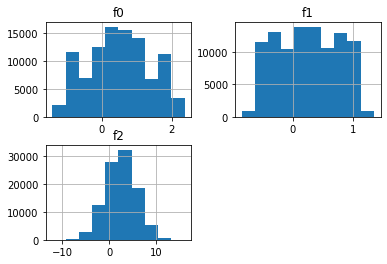

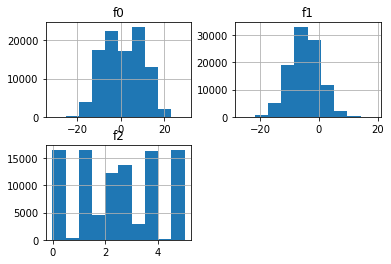

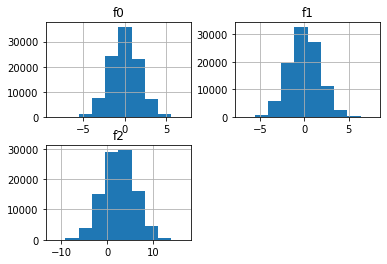

In [5]:
for df in dfs:
    df[['f0','f1','f2']].hist()

In [6]:
for df in dfs:
    print(df.corr())
    print("_" * 80)

               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000
________________________________________________________________________________
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000
________________________________________________________________________________
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000
________________________________________________________________________________


**Вывод:**
* Загрузили датафреймы
* Посмотрели общую информацию о признаках в датафрейме: пропусков и дубликатов нету. Распределение близко к нормальному, за исключением признака *f2* во втором регионе
* Посмотрели корреляцию признаков в каждом регионе: В первом регионе сильная отрицательная корреляция между *f0* и *f1*; Во втором регигоне очень высокая корреляция у признака *f2* и целевой переменной; В третьем регионе наблюдается та же ситуация у признака *f2* и целевой переменной, в то время как остальные признаки почти не коррелируют

## Обучение и проверка модели
**Напишем функцию, которая будет обучать модель линейной регрессии. В начале разделим датафрейм на тренировочный и валидационный, а затем создадим *features* и *target*. По распределению заметили, что в столбце *f2* разброс сильнее, чем в столбцах *f0* b *f1*, поэтому нужно стандартизировать признаки методом StandardScaler(). Далее функция посчитает RMSE, среднее значение в столбце *product* и средний объем сырья**

In [7]:
rndst = 12345

In [8]:
def training(df):
    df_train, df_valid = train_test_split(df, test_size = 0.25, random_state = rndst)
    
    features_train = df_train.drop(['product', 'id'], axis = 1)
    target_train = df_train['product']
    features_valid = df_valid.drop(['product', 'id'], axis = 1)
    target_valid = df_valid['product']
    
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = pd.Series(model.predict(features_valid))
    
    RMSE = np.sqrt(mean_squared_error(predictions, target_valid))
    avg_prod = sum(predictions)/len(predictions)
    
    print('RMSE: {0:.3f}'.format(RMSE))
    print('Average Product: {0:.3f}'.format(avg_prod))
    print('Average predicted volume:', np.round(predictions.mean(),2))
    return (predictions, target_valid.reset_index(drop = True))

In [9]:
# сохраним значения для дальнейшей работы
predict0, target_valid_0 = training(df0)
predict1, target_valid_1 = training(df1)
predict2, target_valid_2 = training(df2)

RMSE: 37.579
Average Product: 92.593
Average predicted volume: 92.59
RMSE: 0.893
Average Product: 68.729
Average predicted volume: 68.73
RMSE: 40.030
Average Product: 94.965
Average predicted volume: 94.97


In [10]:
i = 1
for df in dfs:
    print(f'Region {i}', ':')
    training(df)
    i += 1
    print("_" * 80)
    print()

Region 1 :
RMSE: 37.579
Average Product: 92.593
Average predicted volume: 92.59
________________________________________________________________________________

Region 2 :
RMSE: 0.893
Average Product: 68.729
Average predicted volume: 68.73
________________________________________________________________________________

Region 3 :
RMSE: 40.030
Average Product: 94.965
Average predicted volume: 94.97
________________________________________________________________________________



**Вывод:**
* Посчитаны RMSE, Average Product, Average Predicted Volume для каждого региона
* Максимальное среднее предсказанное значение в третьем регионе (и самое большое RMSE), самое маленькое RMSE и самое маленькое среднее предсказанное значение объема –– в регионе 2

## Подготовка к расчёту прибыли

In [11]:
budget = 1e10
rev = 450000

In [12]:
breakeven_point = np.round(budget / rev, 2)
breakeven_point

22222.22

In [13]:
best_volume = np.round(breakeven_point / 200, 2)
best_volume

111.11

In [14]:
i = 1
for df in dfs:
    profit = np.round((df['product'].mean() - best_volume)/best_volume * 100, 3)
    print(f'Профит по регигону {i}:', profit)
    print(f'Средний запас нефти на скважину в регионе {i}:', np.round(df['product'].mean(), 3))
    print("_" * 80)
    print()
    i += 1
    

Профит по регигону 1: -16.749
Средний запас нефти на скважину в регионе 1: 92.5
________________________________________________________________________________

Профит по регигону 2: -38.057
Средний запас нефти на скважину в регионе 2: 68.825
________________________________________________________________________________

Профит по регигону 3: -14.499
Средний запас нефти на скважину в регионе 3: 95.0
________________________________________________________________________________



**Получили, что у каждого региона профит отрицательный (если взять рандомные 200 точек). В дальнейшем будем опираться на 200 лучших. Средний объем каждого региона меньше break-even point. Логично, что эти два высказывания взаимосвязаны**

In [15]:
predict_200_0 = pd.Series(predict0, target_valid_0.index).sort_values(ascending = False)[:200]
sum_200_0 = predict_200_0.sum()
profit_200_0 = sum_200_0 * rev - budget
print('Volume in 1st region:', sum_200_0.round(2))
print('Profit in 1nd region:', np.round(profit_200_0/10**9, 2), 'Billion')
print("_"*80)
predict_200_1 = pd.Series(predict1, target_valid_1.index).sort_values(ascending = False)[:200]
sum_200_1 = predict_200_1.sum()
profit_200_1 = sum_200_1 * rev - budget
print('Volume in 2nd region:', sum_200_1.round(2))
print('Profit in 2nd region:', np.round(profit_200_1/10**9, 2), 'Billion')
print("_"*80)
predict_200_2 = pd.Series(predict2, target_valid_2.index).sort_values(ascending = False)[:200]
sum_200_2 = predict_200_2.sum()
profit_200_2 = sum_200_2 * rev - budget
print('Volume in 3rd region:', sum_200_2.round(2))
print('Profit in 3nd region:', np.round(profit_200_2/10**9, 2), 'Billion')

Volume in 1st region: 31102.33
Profit in 1nd region: 4.0 Billion
________________________________________________________________________________
Volume in 2nd region: 27746.03
Profit in 2nd region: 2.49 Billion
________________________________________________________________________________
Volume in 3rd region: 29603.9
Profit in 3nd region: 3.32 Billion


**Посчитали объем и профит для каждого региона с 200 лучшими точками. Лучшая прибыль у первого региона –– 4 миллиарда рублей; больший объем также у первого региона –– 31102 тыс. баррелей**

## Расчёт прибыли и рисков 

In [18]:
rndst = np.random.RandomState(12345)
n_500 = 500 
best = 200

# Функция для расчета прибыли
def profit_200(target, predict, best):
    predict_200 = predict.sort_values(ascending=False)
    target_200 = target[predict_200.index][:best]
    return target_200.sum() * rev - budget
    
    
def profit_risk_bootstrap(predictions, target):
    profit = []
    
    for i in range(1000):
        target_subsample = target.sample(n_500, replace = True, random_state = rndst)
        predict_subsample = predictions[target_subsample.index]
        
        profit.append(profit_200(target, predict_subsample, best))

    profit = pd.Series(profit)
    
    lower = np.round(profit.quantile(0.025), 3)
    upper = np.round(profit.quantile(0.975), 3)
    CI95 = (lower, upper)
    
    mean_profit = sum(profit)/len(profit)
    
    risk_of_loss = (profit < 0).mean() * 100
    
    return (CI95, mean_profit, risk_of_loss)

In [19]:
i = 1
for predicted, target in zip([predict0, predict1, predict2],
                             [target_valid_0, target_valid_1, target_valid_2]):
    CI, mean, risk = profit_risk_bootstrap(predicted, target)
    
    print(f'Region {i}:')
    i += 1
    print()
    print('95% Confidence Interval:', CI)
    print('Mean Profit:',np.round(mean, 3))
    print('Risk of Loss:', np.round(risk,2))
    print('_' * 80)

Region 1:

95% Confidence Interval: (-111215545.89, 909766941.553)
Mean Profit: 396164984.802
Risk of Loss: 6.9
________________________________________________________________________________
Region 2:

95% Confidence Interval: (78050810.752, 862952060.264)
Mean Profit: 461155817.277
Risk of Loss: 0.7
________________________________________________________________________________
Region 3:

95% Confidence Interval: (-112227625.379, 934562914.551)
Mean Profit: 392950475.171
Risk of Loss: 6.5
________________________________________________________________________________


## Общий вывод
* Загрузили и изучили данные. В данных не обнаружилось пропусков и дубликатов, почти у всех признаков распределение близко к нормальному, за исключением *f2* во втором регионе
* Обучили модель линейной регрессии на каждом датасете
* Посчитали средние значения для каждого региона. Пришли к выводу об убыточности добычи нефти в каждом регионе при случайном выборе точек бурения скважин
* Получили те же значения для каждого региона, но с учетом выбора 200 лучших точек для бурения. Прибыль теперь есть, и самая большая прибыль и самый большой объем нефти у первого региона. 
* Выполнили процедуру бутстрепа, посчитали среднюю прибыль, риск убытка и 95% доверительный интервал для каждого региона. Исходя из полученных данных, предпочтительнее всего выглядит регион 2, так как в остальных регионах доверительный интервал содержит 0 (доверительный интервал включает в себя как положительные, так и отрицательные значения), соответственно и риск убытка будет наименьшим во втором регионе. 